In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(['science', 'grid'])
matplotlib.rcParams["font.size"] = "12"

import torch
import torch.nn as nn
from torch.autograd import grad

In [6]:
def plot_solution(domain_steps, predicted_solution, known_solution=None, size=(5, 5), title=None, save=False, dpi=300):
       
    fig = plt.figure(figsize=size)
    
    if known_solution is not None:
        plt.plot(domain_steps[:, 0], known_solution, label='Numerical solution')
            
    plt.plot(domain_steps[:, 0], predicted_solution, label='Predicted solution')
    plt.xlabel('t')
    plt.ylabel('x(t)')
    
    plt.legend()
    plt.title(title)

    if save:
        plt.savefig(f'./images/oscillator/{title}.png', dpi=dpi)
        
    plt.show()

In [3]:
from scipy.integrate import solve_ivp

class DampedHarmonicOscillator:
    def __init__(self, T, params, initial_conditions):
        
        self.T = T
        self.d, self.w0 = params
        self.init_vals = torch.tensor(initial_conditions)

        self.numerical_solution = self._solve()
    
    def loss_initial(self, model):
        zero = torch.tensor([0.], requires_grad=True)
        x = model(zero)
        v = grad(x, zero, grad_outputs=torch.ones_like(x), create_graph=True)[0]
        return torch.mean(torch.square(torch.hstack([x, v]) - self.init_vals))
    
    def loss_physical(self, model, t):
        x = model(t)
        v = grad(x, t, grad_outputs=torch.ones_like(x), create_graph=True)[0]
        a = grad(v, t, grad_outputs=torch.ones_like(x), create_graph=True)[0]
        
        return torch.mean(torch.square(a + 2*self.d*self.w0 * v + self.w0**2 * x))
    
    def _solve(self):
        def harmonic_oscillator(t, y, d, w0):
            x, v = y
            dxdt = v
            dvdt = -2*d*w0 * v - w0**2 * x
            return [dxdt, dvdt]

        solution = solve_ivp(harmonic_oscillator, 
                             (0, self.T), 
                             self.init_vals, 
                             args=(self.d, self.w0), 
                             t_eval=np.linspace(0, self.T, 128))
        
        return solution.y[0]
    
class FeedForwardNetwork(nn.Module):
    def __init__(self, hidden_layers, hidden_dim, input_dim=1, output_dim=1):
        super(FeedForwardNetwork, self).__init__()
        
        self.L = hidden_layers
        self.W = hidden_dim
        
        self.model = nn.Sequential()
        self.activation = nn.Tanh()
        
        inp_linear = nn.Linear(input_dim, hidden_dim)
        out_linear = nn.Linear(hidden_dim, output_dim)
        
        self.model.add_module('input', inp_linear)
        self.model.add_module('activ0', self.activation)
        for i in range(hidden_layers - 1):
            linear = nn.Linear(hidden_dim, hidden_dim)
            self.model.add_module(f'linear{i+1}', linear)
            self.model.add_module(f'activ{i+1}', self.activation)
        self.model.add_module('output', out_linear)
        
    def forward(self, x):
        return self.model(x)
    
    def weights_norm(self):
        S = 0
        with torch.no_grad():
            for name, parameter in self.model.named_parameters():
                # print(name, torch.linalg.norm(parameter))
                S += torch.linalg.norm(parameter)
        return S.item() / self.L

In [4]:
def rmse(predicts, target):
    return np.sqrt(np.square(predicts - target).mean())

def train(
    problem,
    model,
    alpha, beta, num_iters, N_F,
    optimizer, lr,
    print_every=1000, collect_every=1000, tolerance=1e-3
):
    collocation_t = torch.linspace(0, problem.T, N_F, requires_grad=True).reshape(-1, 1)
    test_points = torch.linspace(0, problem.T, 128).reshape(-1, 1)
    
    losses, weights = [], []
    
    optim = optimizer(model.parameters(), lr=lr)
    
    for i in range(0, num_iters + 1):
        
        optim.zero_grad()
        
        L_I = problem.loss_initial(model)
        L_F = problem.loss_physical(model, collocation_t)
    
        L = alpha * L_I + beta * L_F
        
        L.backward()
        optim.step()
        
        if i % print_every == 0 and i > 0:
            predicts = model(test_points).flatten().detach().numpy()
            print(f'Iteration {i} --- Loss {L.item()} --- RMSE {rmse(predicts, problem.numerical_solution)}')
            
        if collect_every > 0 and i % collect_every == 0:
            predicts = model(test_points).flatten().detach().numpy()
            losses.append(np.array([L.item(), rmse(predicts, problem.numerical_solution)]))
            weights.append(model.weights_norm())
        
        if L.item() < tolerance:
            if i % collect_every != 0:
            # print(f'Model has reached {L.item():.5f} error. Early stopping.')
                predicts = model(test_points).flatten().detach().numpy()
                losses.append(np.array([L.item(), rmse(predicts, problem.numerical_solution)]))
                weights.append(model.weights_norm())
            break
    
    return i + 1, np.array(losses), np.array(weights)

In [5]:
problem = DampedHarmonicOscillator(10, (0.2, 2.0), (5.0, 7.0))
model = FeedForwardNetwork(2, 32)

iters, losses, weights = train(
    problem=problem,
    model=model,
    alpha=1.0, beta=0.5, num_iters=10000, N_F=256,
    optimizer=torch.optim.Adam, lr=1e-3,
    print_every=5000, collect_every=500, tolerance=0
)

c:\Users\dlaptev\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Iteration 5000 --- Loss 0.03355804458260536 --- RMSE 0.11978400561085219
Iteration 10000 --- Loss 0.0027419491671025753 --- RMSE 0.020289902188623206


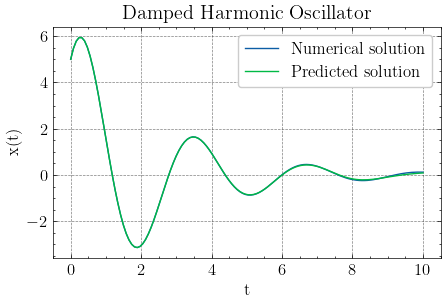

In [7]:
domain = torch.linspace(0, 10, 128).reshape(-1, 1)
predictions = model(domain).detach()
plot_solution(domain.numpy(), predictions.numpy(), problem.numerical_solution, size=(5, 3), title='Damped Harmonic Oscillator', save=True)

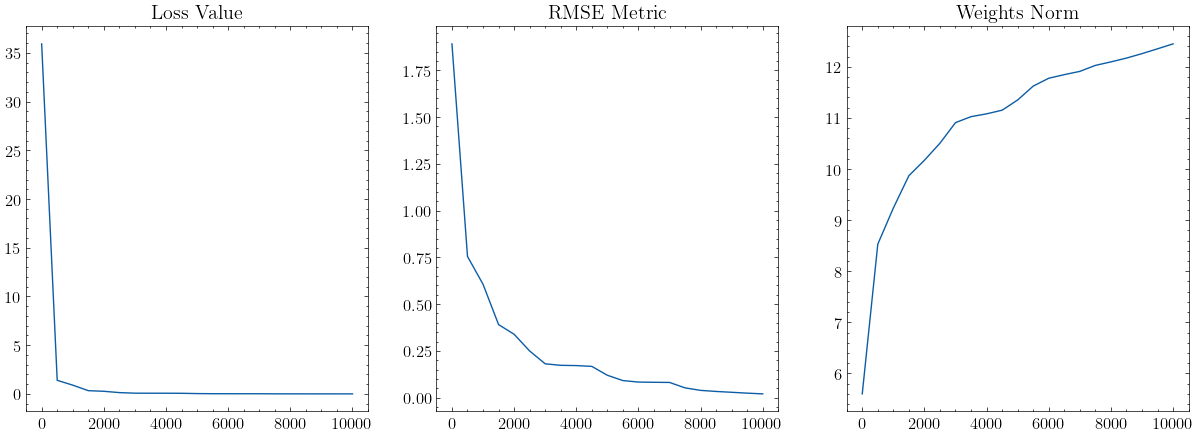

In [8]:
def plot_collected(losses, weights, collect_every, plot_from=0, figsize=(15, 5)):
    iters = np.arange(0, collect_every * len(weights), collect_every)
    
    fig, axs = plt.subplots(1, 3, figsize=figsize)
    
    axs[0].plot(iters[plot_from:], losses[plot_from:,0])
    axs[1].plot(iters[plot_from:], losses[plot_from:,1])
    axs[2].plot(iters[plot_from:], weights[plot_from:])

    axs[0].grid(); axs[1].grid(); axs[2].grid()

    axs[0].set_title('Loss Value')
    axs[1].set_title('RMSE Metric')
    axs[2].set_title('Weights Norm')

    plt.show()
    
plot_collected(losses, weights, 500)

In [ ]:
import csv
from tqdm import tqdm

replace_existing = False

with open(
    './pinn_training.csv', 
    'w' if replace_existing else 'a'
    ) as report:
    writer = csv.writer(report, delimiter=',')
    
    for iteration in tqdm(range(250)):
        T = np.random.choice(np.arange(5, 21))

        d = np.random.uniform(0.1, 5.0)
        w0 = np.random.uniform(0.1, 5.0)

        x_0 = np.random.uniform(-10.0, 10.0)
        v_0 = np.random.uniform(-10.0, 10.0)

        L = np.random.choice(np.arange(1, 8))
        W = np.random.choice(np.arange(1, 33))

        alpha = np.random.uniform(0.1, 2.0)
        beta = np.random.uniform(0.01, 1.0)
        num_iters = 10000
        N_F = np.random.choice(np.arange(36, 257))
        
        optimizer = torch.optim.Adam
        lr = np.random.uniform(1e-5, 1.0)

        iterations, losses, weights = train(
            DampedHarmonicOscillator(T, (d, w0), (x_0, v_0)),
            FeedForwardNetwork(L, W),
            alpha, beta, num_iters, N_F,
            optimizer, lr,
            print_every=num_iters*2, collect_every=num_iters,
            plot_after_training = False
        )
        
        writer.writerow([
            T, d, w0, x_0, v_0, 
            L, W,
            alpha, beta, iterations, N_F, lr,
            losses[-1, 0], losses[-1, 1], weights[-1]
        ])